## New Dark Matter (DM) Simulation 
Using model from ... 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import nbformat
import plotly.graph_objects as go
import plotly.express as px
from scipy.integrate import nquad, dblquad
import plotly.io as pio
pio.renderers.default = "notebook"

np.set_printoptions(threshold=10)

In [54]:
class DMModel():
    def __init__(self, g = 6.67e-11, dmMass = 10000, galaxyRadius = 5.2e20):
        self.g = g
        self.dmMass = dmMass
        self.galaxyRadius = galaxyRadius
        

    def RunSimulation(self, numRegions=100, integralSampleNum=500):
        print("Sectioning galaxy into", (numRegions - 1)**3, "regions.")
        self.SectionGalaxy(numRegions=numRegions)

        print("Integrating sections.")
        self.FindDMCounts(integralSampleNum=integralSampleNum)

        print("Populating galaxy with DM bodies.")
        self.PopulateDMGalaxy()



    def DensityFunction(self, r, theta):
        # Function for radius, dependent on radius from galactic center and angle to the vertical axis.
        # Original function is in 2D

        # Needs better mean density value, this is the DM density at the Sun's position taken from Wikipedia
        meanDensity = 5.955e-22#(1/3) * 3e-28
        n = 1

        v0 = np.sqrt(4 * np.pi * self.g * meanDensity * self.galaxyRadius**2)
        pTheta = (1 + np.cos(theta))**(n + 1) + (1 - np.cos(theta))**(n + 1)
        sTheta = (4 * (n + 1) * np.sin(theta)**(2 * n))/(pTheta)**2
        rDensity = v0**2 / (4 * np.pi * self.g * r**2)
        density = rDensity * sTheta
        return density
    
    
    def SectionGalaxy(self, numRegions = 100):
        # Section galaxy into regions, numRegions^3 for each direction.
        # Store rMin, rMax, thetaMin, thetaMax, phiMin, phiMax for each region.
        rArray = np.linspace(0, self.galaxyRadius, numRegions)
        thetaArray = np.linspace(0, np.pi, numRegions)
        phiArray = np.linspace(0, 2*np.pi, numRegions)

        self.regions = []
        for i in range(numRegions - 1):
            for j in range(numRegions - 1):
                for k in range(numRegions - 1):
                    rMin, rMax = rArray[i], rArray[i + 1]
                    thetaMin, thetaMax = thetaArray[j], thetaArray[j + 1]
                    phiMin, phiMax = phiArray[k], phiArray[k + 1]

                    self.regions.append((rMin, rMax, thetaMin, thetaMax, phiMin, phiMax))


    def MonteCarloIntegral(self, N, region):
        # Random array of points within space for r, theta and phi.
        r, theta, phi = self.SampleRegion(region, N)

        regionVolume = (
            (region[1]**3 - region[0]**3)/3 *
            (np.cos(region[2]) - np.cos(region[3])) *
            (region[5] - region[4])
        )
        values = self.DensityFunction(r, theta)
        
        return regionVolume * np.mean(values)


    def FindDMCounts(self, integralSampleNum = 500):
        # Integrate over each region of the galaxy to get total mass.
        #
        # Then divide total mass by DM Mass to get N for number of particles.
        self.regionMasses = np.array([
            self.MonteCarloIntegral(integralSampleNum, region) for region in self.regions
        ])

        
        
        # Until I find a way to deal with trillions of particles, 
        # I make the DM Mass larger by a factor of however many digits long the avg number of 
        # DM counts there are in each region.
        # This adjusts the DM Mass enough so that the average number of DM per region is < 10.
        #
        # For a million+ regions that will have to do for now
        dmCounts = self.regionMasses / self.dmMass
        if np.mean(dmCounts) > 10:
            avgDMCount = int(np.mean(dmCounts))
            numDigits = len(list(str(avgDMCount)))  # Find how many digits
            self.dmMass *= 10**(numDigits - 1)

            
            print("Multiplied DM Mass by 10^" + str(numDigits) + "to improve performance.")
            print("DM Mass is now", self.dmMass, "kg")

        self.numDM = self.regionMasses / self.dmMass
        # print(self.numDM)
    
    def GetDMCounts(self):
        return self.numDM
    
    def SphericalToCartesian(self, r, theta, phi):
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)
        return np.column_stack((x, y, z))
    
    def SampleRegion(self, region, N):
        rMin, rMax, thetaMin, thetaMax, phiMin, phiMax = region

        u1 = np.random.rand(N)
        u2 = np.random.rand(N)

        r = (u1 * (rMax**3 - rMin**3) + rMin**3)**(1/3)
        theta = np.arccos(
                np.cos(thetaMin) - u2 * (np.cos(thetaMin) - np.cos(thetaMax))
            )
        phi = np.random.uniform(phiMin, phiMax, N)

        return r, theta, phi
    
    
    def PopulateDMGalaxy(self):
        # With number of particles per region, now it's time to create a matrix with all DM particles.
        #
        # For decimals, summon as many as the last whole integer and subtract that from the total number of particles.
        # With the remaining decimal (<1), invert the number (1/decimal) and pick a random number between 1 and the nearest integer.
        # If the random number is 1 then an additional particle is summoned, otherwise it is not.

        allPositions = []
        for i in range(len(self.regions)):

            N = int(self.numDM[i])
            frac = self.numDM[i] - N
            if np.random.rand() < frac:
                N += 1

            r, theta, phi = self.SampleRegion(self.regions[i], N)
            positions = self.SphericalToCartesian(r, theta, phi)

            allPositions.append(positions)
        
        self.dmCartesianCoordinates = np.vstack(allPositions)
        return self.dmCartesianCoordinates

    def FindOrbitalVelocity(self, M, r):
        return np.sqrt(self.g * M / r)


    def GetRotationCurve(self, N = 10):
        # Summons N randomly placed test particles in the galaxy of DM.
        # Find the total mass of DM particles inside the radius of the test particles, 
        # then use that to find the orbital velocity required to have a stable circular orbit at that radius.

        fullRegion = (0, self.galaxyRadius, 0, np.pi, 0, 2*np.pi)
        r, theta, phi = self.SampleRegion(fullRegion, N)

        self.testParticlesCartesianCoordinates = self.SphericalToCartesian(r, theta, phi)

        dmRadii = np.linalg.norm(self.dmCartesianCoordinates, axis=1)
        testRadii = np.linalg.norm(self.testParticlesCartesianCoordinates, axis=1)

        interiorCounts = np.array([np.sum(dmRadii < R) for R in testRadii])
        interiorMasses = interiorCounts * self.dmMass
        orbitalVelocities = self.FindOrbitalVelocity(interiorMasses, testRadii)

        self.PlotRotationCurve2D(testRadii, orbitalVelocities)


    def TestMonteCarloAccuracy(self, numTestRegions = 10):
        testRegions = np.random.randint(0, len(self.regions), numTestRegions)

        monteMasses = [self.regionMasses[i] for i in testRegions]
        quadMasses = []
        for i in testRegions:
            # i is the index for the region in either self.regions and self.regionMasses
            rMin, rMax, thetaMin, thetaMax, phiMin, phiMax = self.regions[i]

            # Density is independent of phi
            phiWidth = phiMax - phiMin

            # Integrand for dblquad
            def integrand(r, theta):
                return self.DensityFunction(r, theta) * r**2 * np.sin(theta)

            # Fixed r bounds
            rLower = lambda theta: rMin
            rUpper = lambda theta: rMax

            # Integrate
            innerIntegral, error = dblquad(
                integrand,
                thetaMin, thetaMax,
                rLower, rUpper 
            )

            quadMass = innerIntegral * phiWidth
            quadMasses.append(quadMass)

            print("For region", i, "quad integral got", quadMass, "and Monte got", self.regionMasses[i])

        integrationError = [abs(quadMasses[i] - monteMasses[i]) / quadMasses[i] for i in range(numTestRegions)]
        return integrationError
    

    def PlotDMPositions3D(self, alpha = 0.1, lineWidth = 0.001, plotDimensions=1100, N=100000):
        mTokPc = 1.856e-18
        
        randomSample = np.random.randint(0, len(self.dmCartesianCoordinates), N)
        X = [self.dmCartesianCoordinates[i][0] * mTokPc for i in randomSample]
        Y = [self.dmCartesianCoordinates[i][1] * mTokPc for i in randomSample]
        Z = [self.dmCartesianCoordinates[i][2] * mTokPc for i in randomSample]

        df = pd.DataFrame({
                "X": X,
                "Y": Y,
                "Z": Z
            })

        fig = px.scatter_3d(
            data_frame=df,
            x="X",
            y="Y",
            z="Z",
            opacity=alpha,
            # size=lineWidth
        )
        fig.update_layout(
            scene=dict(
                xaxis=dict(range=[-plotDimensions, plotDimensions], title="X (kPc)"),
                yaxis=dict(range=[-plotDimensions, plotDimensions], title="Y (kPc)"),
                zaxis=dict(range=[-plotDimensions, plotDimensions], title="Z (kPc)")
            )
        )

        fig.show()
    
    def PlotRotationCurve2D(self, x, y):
        mTokPc = 1.856e-18
        x *= mTokPc
        
        fig = plt.figure(figsize=(16,12))
        ax = fig.add_subplot(111)

        ax.scatter(x, y)
        ax.set_xlabel("Radius from GC (kPc)")
        ax.set_ylabel("Orbital Velocity (m/s)")
        plt.show()

    

In [55]:
model = DMModel(dmMass=1e22)
model.RunSimulation(numRegions=100)

Sectioning galaxy into 970299 regions.
Integrating sections.
Multiplied DM Mass by 10^15to improve performance.
DM Mass is now 1e+36 kg
Populating galaxy with DM bodies.


In [56]:
model.PlotDMPositions3D(alpha = 0.005, lineWidth=0.01, N = 100000)

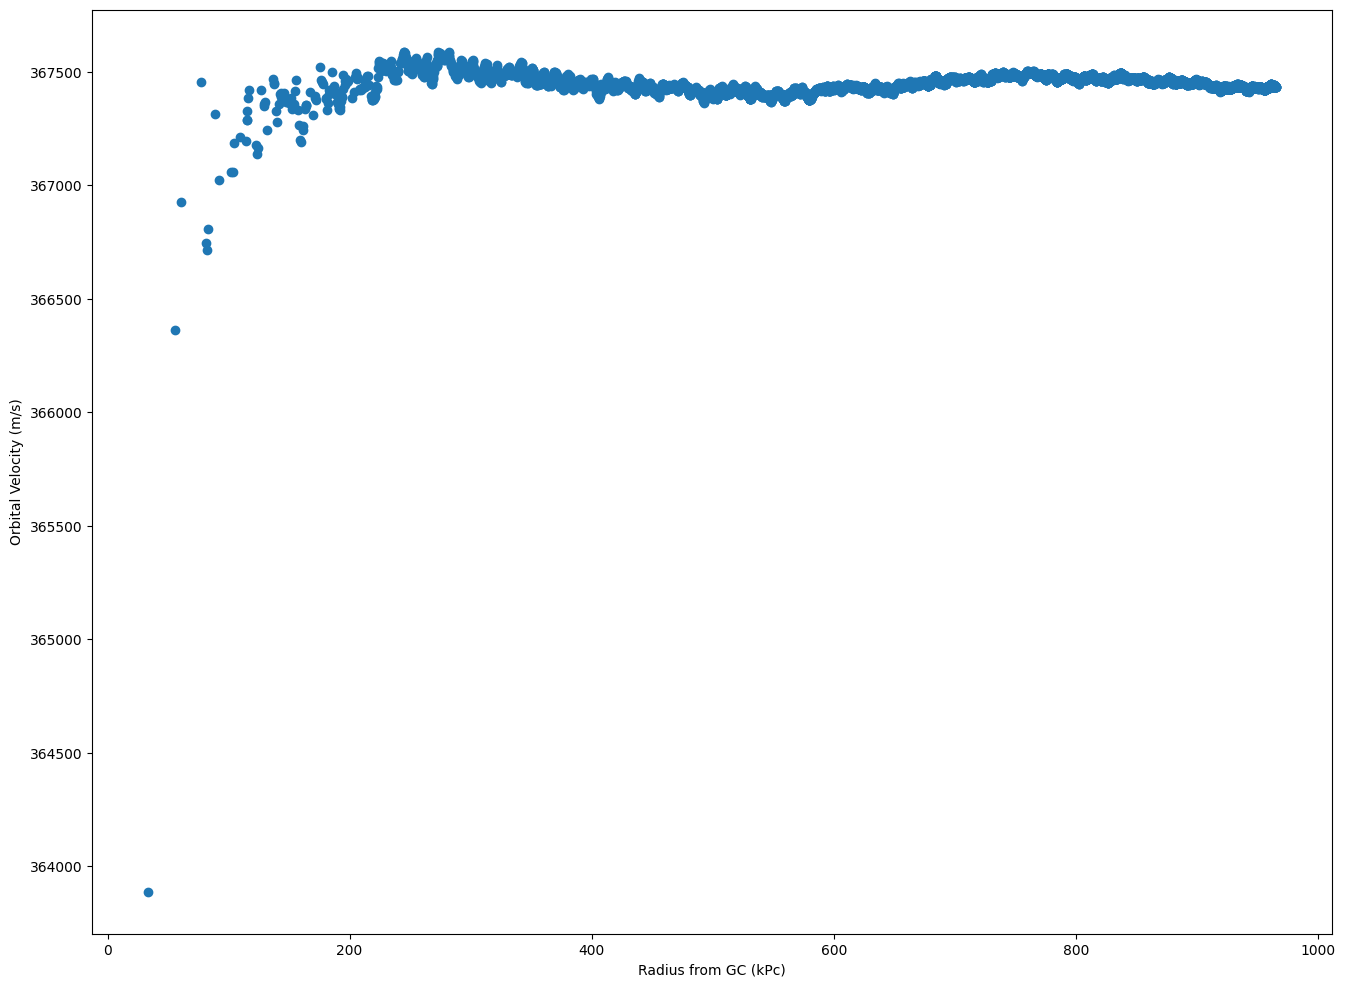

In [62]:
model.GetRotationCurve(N=10000)

In [15]:
model.dmCartesianCoordinates

array([[ 5.84487402e+17,  2.46109905e+17,  3.88830915e+18],
       [ 8.54103284e+17, -3.42979617e+17,  4.82399369e+18],
       [-5.39122912e+17,  3.91838175e+17,  3.13735531e+18],
       ...,
       [ 1.15837522e+20,  4.59627994e+19, -4.99722507e+20],
       [-1.07897968e+20, -1.93210864e+17, -5.04166667e+20],
       [-7.18858639e+18, -9.82207580e+19, -5.06518429e+20]],
      shape=(1052037, 3))

In [ ]:
dmCounts = model.GetDMCounts()
print("The region with the fewest DM Bodies has", np.min(dmCounts))
print("The region with the Most DM Bodies has", np.max(dmCounts))
print("The average DM Bodies per region is", np.mean(dmCounts))
#print(np.sum(dmCounts))
print("Total mass of Dark Matter in galaxy (kg) =", np.sum(dmCounts) * model.dmMass)
print("Estimated mass of the Milky Way Galaxy =", 1.15e12 * 1.989e30)
print("This models DM mass percentage =", (np.sum(dmCounts) * model.dmMass * 100) / (1.15e12 * 1.989e30), "%")

The region with the fewest DM Bodies has 4.954334886128451e-06
The region with the Most DM Bodies has 68.11968507700969
The average DM Bodies per region is 1.0843499850851581
Total mass of Dark Matter in galaxy (kg) = 1.0521437061781439e+42
Estimated mass of the Milky Way Galaxy = 2.28735e+42
This models DM mass percentage = 45.99836956207594 %


In [ ]:
integrationError = model.TestMonteCarloAccuracy()

For region 596469 quad integral got 9.192284466959733e+34 and Monte got 9.201011899666893e+34
For region 280468 quad integral got 2.104408627708277e+36 and Monte got 2.102849484393831e+36
For region 500391 quad integral got 4.636517044991439e+33 and Monte got 4.6285203300530106e+33
For region 937217 quad integral got 2.104408627708256e+36 and Monte got 2.1055944369113547e+36
For region 694378 quad integral got 1.1379639073909738e+35 and Monte got 1.138936983999602e+35
For region 599128 quad integral got 5.746392914851775e+34 and Monte got 5.752408445631805e+34
For region 598760 quad integral got 2.447301741327222e+34 and Monte got 2.463765153907256e+34
For region 640791 quad integral got 2.1044086277082814e+36 and Monte got 2.103589995339366e+36
For region 140335 quad integral got 1.2148568319044755e+36 and Monte got 1.2167463334482996e+36
For region 369968 quad integral got 5.1745490295213125e+35 and Monte got 5.175648890331531e+35


In [ ]:
integrationError

[np.float64(0.000949430224720471),
 np.float64(0.0007408938045192694),
 np.float64(0.00172472458546587),
 np.float64(0.0005634880923245937),
 np.float64(0.0008551032263044921),
 np.float64(0.0010468359663472848),
 np.float64(0.006727169070335198),
 np.float64(0.0003890082744086537),
 np.float64(0.0015553285738715494),
 np.float64(0.0002125520125412927)]